In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_28655/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Full Fidelity Scan

In [20]:
from helper_funcs.utils import *

tau_1 = 45 * ns
tau_readout = 300 * ns
tau_3 = 40 * ns

acq_duration_dt = 48
acq_latency_dt = get_dt_from(320 * ns)
acq_start = 0.0 * ns
acq_end = 750 * ns
acq_delay_linspace = np.linspace(acq_start, acq_end, int((acq_end - acq_start)/acq_duration_dt/dt))

280


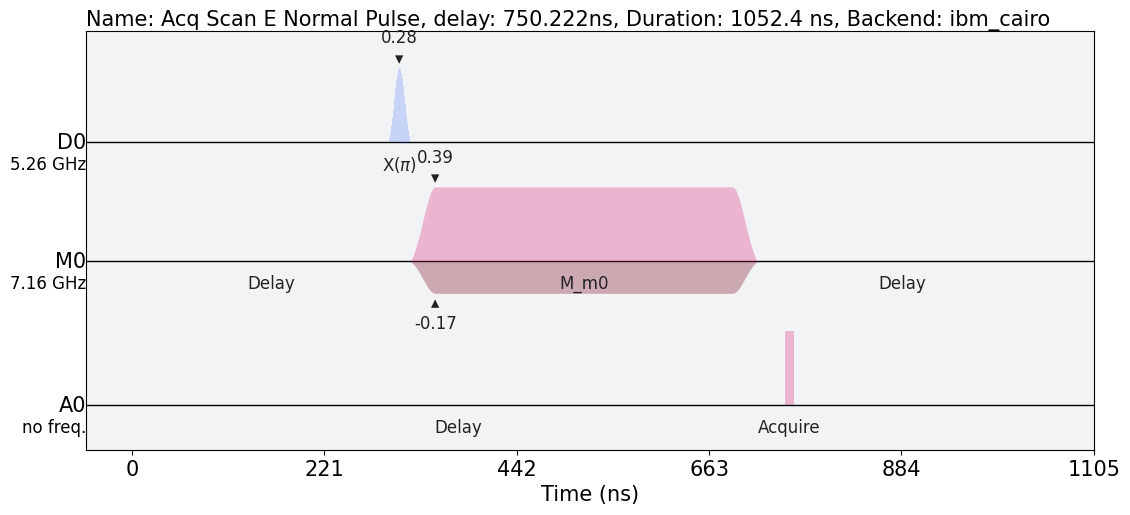

In [22]:
opt_exp_g = []
opt_exp_e = []
normal_exp_g = []
normal_exp_e = []

for acq_delay_sec in  acq_delay_linspace:
    acq_delay_dt = get_dt_from(acq_delay_sec)
    
    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Acq Scan G Opt Pulse, delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as opt_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        
        pulse.play(
            pulse.Constant(duration=get_dt_from(tau_1), amp=1.0),
            meas_chan
        )
        pulse.play(
            pulse.Constant(duration=get_dt_from(tau_readout - tau_1), amp=measure_pulse.amp),
            meas_chan
        )
        pulse.play(
            pulse.Constant(duration=get_dt_from(tau_3), amp=-1.0),
            meas_chan
        )
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    opt_exp_g.append(opt_sched_g)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Acq Scan E Opt Pulse, delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as opt_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)
        
        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        
        pulse.play(
            pulse.Constant(duration=get_dt_from(tau_1), amp=1.0),
            meas_chan
        )
        pulse.play(
            pulse.Constant(duration=get_dt_from(tau_readout - tau_1), amp=measure_pulse.amp),
            meas_chan
        )
        pulse.play(
            pulse.Constant(duration=get_dt_from(tau_3), amp=-1.0),
            meas_chan
        )
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    opt_exp_e.append(opt_sched_e)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Acq Scan G Normal Pulse, delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as normal_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        
        pulse.play(
            measure_pulse,
            meas_chan
        )
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    normal_exp_g.append(normal_sched_g)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Acq Scan E Normal Pulse, delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as normal_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)
        
        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        
        pulse.play(
            measure_pulse,
            meas_chan
        )
        pulse.delay(
            measure_delay.duration,
            meas_chan
        )
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    normal_exp_e.append(normal_sched_e)

total_exp = opt_exp_g + opt_exp_e + normal_exp_g + normal_exp_e

print(len(total_exp))

total_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [23]:
acquisition_checker(total_exp)

num_shots = 4096
rep_delay = 499.0 * 1e-6

In [24]:
job_experiment = backend.run(total_exp, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued (None)

KeyboardInterrupt: 

In [7]:
job_1 = provider.backend.retrieve_job('cpa8cntyx18g008b5ed0')

In [8]:
result_1 = get_results_arr(job_1.result(), qubit)

In [9]:
opt_res_g, opt_res_e, normal_res_g, normal_res_e = result_1.reshape(4, -1, num_shots)

(46, 4096)


In [10]:
opt_fidelity = get_fidelity(opt_res_g, opt_res_e)
normal_fidelity = get_fidelity(normal_res_g, normal_res_e)

opt_pf = -np.log10(1. - opt_fidelity)
normal_pf = -np.log10(1. - normal_fidelity)

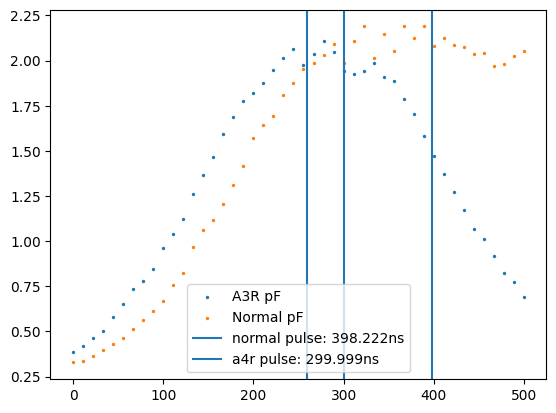

In [15]:
normal_meas_duration = measure_pulse.duration * dt
a4r_meas_duration = tau_readout + tau_3

plt.scatter(acq_delay_linspace/ns, opt_pf, label='A3R pF', s=2)
plt.scatter(acq_delay_linspace/ns, normal_pf, label='Normal pF', s=2)
plt.axvline(x=normal_meas_duration/ns, label=f'normal pulse: {int(1e3*normal_meas_duration/ns)/1e3}ns')
plt.axvline(x=a4r_meas_duration/ns, label=f'a4r pulse: {int(1e3*a4r_meas_duration/ns)/1e3}ns')
plt.axvline(x=tau_readout/ns)
plt.legend()
plt.show()